# Найти на изображении присутствие другого изображения.

Опять уточним требования:

- Есть изобржение template, присутсвие которого нужно обнаружить main image (image), если такое имеется
- Нужно детектировать, если на image есть template с изменёнными цветами
- Линейных трасформаций нет, то есть вращения, отражения, аффинные трансформации не учитываем
- Предполагаем, что возможным template на image не встретиться больше одного 

In [2]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

img_path = Path("data/img")

In [9]:
def show_in_row(images, titles=None):
    """Отображает несколько картинок в ряд"""
    count = len(images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx + 1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = images[idx]
        cmap = "gray" if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
    plt.tight_layout()
    plt.show()

Возьмём логотип компании, в которую хотим попасть)

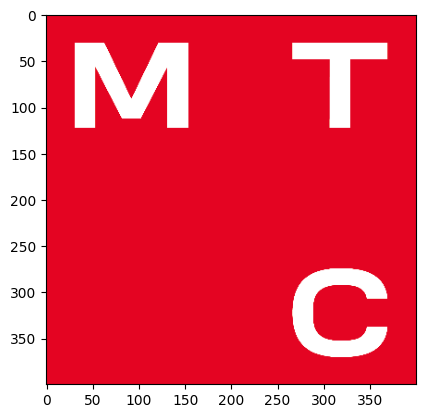

In [4]:
mts_logo: np.ndarray = cv2.imread(img_path / "mts_logo.png", cv2.IMREAD_COLOR)
mts_logo = cv2.cvtColor(mts_logo, cv2.COLOR_BGR2RGB)
mts_logo = cv2.resize(mts_logo, (400, 400))

plt.imshow(mts_logo)
plt.show()

Также возьмём логотип компании, в которой есть похожий элемент

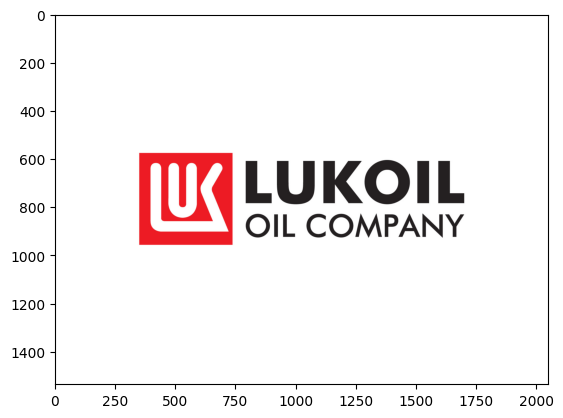

In [5]:
lukoil_logo: np.ndarray = cv2.imread(img_path / "lukoil_logo.jpg", cv2.IMREAD_COLOR)
lukoil_logo = cv2.cvtColor(lukoil_logo, cv2.COLOR_BGR2RGB)

plt.imshow(lukoil_logo)
plt.show()

Предложим, что какой-то недображелатель режил зарегистрировать знак лукойла с логотипом МТС

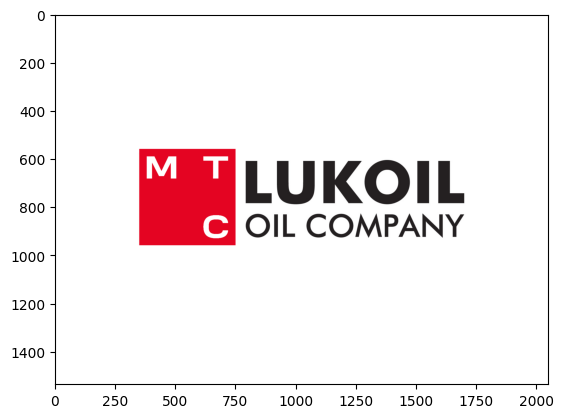

In [14]:
h, w, _ = mts_logo.shape
x_offset, y_offset = 350, 560

mts_on_lukoil_logo = lukoil_logo.copy()
mts_on_lukoil_logo[y_offset : y_offset + h, x_offset : x_offset + w] = mts_logo

plt.imshow(mts_on_lukoil_logo)
plt.show()

In [24]:
def detect(
    image: np.ndarray, template: np.ndarray
) -> tuple[bool, np.ndarray, np.ndarray]:
    """Функция, которая пытается найти template на image.

    Args:
        image (np.ndarray): основная картинка
        template (np.ndarray): паттерн, который ходим найти

    Returns:
        tuple[bool, np.ndarray, nd.ndarray]: есть ли паттерн, задетектированный паттерн на картинке (если найден), мэтчинг линий (если найден)
    """
    # сохраним цветные версии
    image_color = image.copy()
    template_color = template.copy()

    # конвертируем цвета в серый, чтобы быть инвариантым к цвету паттерна
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # используем бэйзлайн детектор
    detector = cv2.SIFT.create()

    # находим keypoints и descriptors на обеих картинках
    kp_image, des_image = detector.detectAndCompute(image, None)
    kp_template, des_template = detector.detectAndCompute(template, None)

    # исползуем BFMatcher чтобы найти matches между descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_template, des_image, k=2)

    # FLANN stands for Fast Library for Approximate Nearest Neighbors
    # https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    # FLANN_INDEX_KDTREE = 1
    # flann = cv2.FlannBasedMatcher(
    #     indexParams=dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
    #     searchParams=dict(checks=50),
    # )
    # matches = flann.knnMatch(des1, des2, k=2)

    # сравниваем через отношение (гиперпараметр) дистанции и добавлеем хорошие совпадения
    good_matches = []
    ratio_thresh = 0.75
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # минимальное количество хороших совпадений, чтобы утверждать, что паттер присутствует (также гиперпараметр)
    MIN_MATCH_COUNT = 10
    if len(good_matches) >= MIN_MATCH_COUNT:
        # извлекаем места, где точки совпали на обеих картинках
        src_pts = np.float32(
            [kp_template[m.queryIdx].pt for m in good_matches]
        ).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_image[m.trainIdx].pt for m in good_matches]).reshape(
            -1, 1, 2
        )

        # считаем есть ли такая матрица, позволяющая перенести точки одной картинки в другую
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if M is not None:
            # получаем размеры паттерна (каналов нет, потому что картинки обезсвечены)
            h, w = template.shape

            # получаем углы паттерна и переводим их в координаты image
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(
                -1, 1, 2
            )
            dst = cv2.perspectiveTransform(pts, M)

            # рисуем полигон около обнарженного паттерна на главной картинке
            img_detected = cv2.polylines(
                image_color, [np.int32(dst)], True, (0, 0, 255), 15, shift=0
            )

            # также можем визуализировать процесс матчинга
            draw_params = dict(
                matchColor=(0, 0, 255),  # рисуем синими линиями сматченные точки
                singlePointColor=None,
                matchesMask=mask.ravel().tolist(),  # рисуем только корректные точки (inliers)
                flags=2,
            )
            img_matches = cv2.drawMatches(
                template_color,
                kp_template,
                image_color,
                kp_image,
                good_matches,
                None,
                **draw_params,
            )

            return True, img_detected, img_matches

    return False, image_color, np.ones(shape=(0))

False


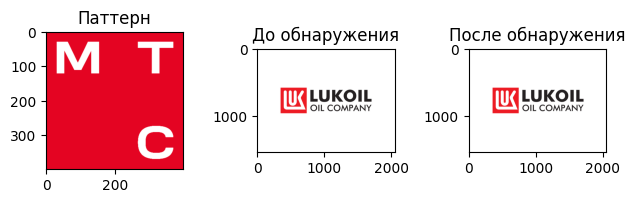

In [25]:
is_detected, detected, matches = detect(lukoil_logo, mts_logo)
print(is_detected)
show_in_row(
    [mts_logo, lukoil_logo, detected],
    titles=["Паттерн", "До обнаружения", "После обнаружения"],
)

True


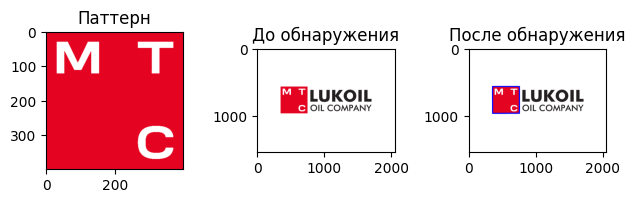

In [26]:
is_detected, detected, matches = detect(mts_on_lukoil_logo, mts_logo)
print(is_detected)
show_in_row(
    [mts_logo, mts_on_lukoil_logo, detected],
    titles=["Паттерн", "До обнаружения", "После обнаружения"],
)

Теперь проверим влияет ли изменение цвета на возможность распознования паттерна. Замаскируем логотип МТС в жёлтый цвет.

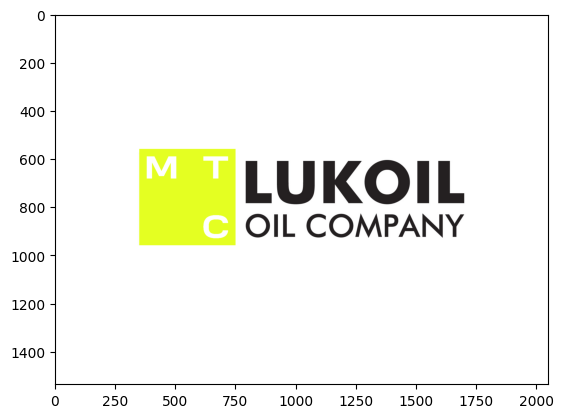

In [33]:
recolored_mts_on_lukoil_logo = mts_on_lukoil_logo.copy()
recolored_mts_on_lukoil_logo[y_offset:y_offset+h, x_offset:x_offset+w, 1] = 255

plt.imshow(recolored_mts_on_lukoil_logo)
plt.show()

True


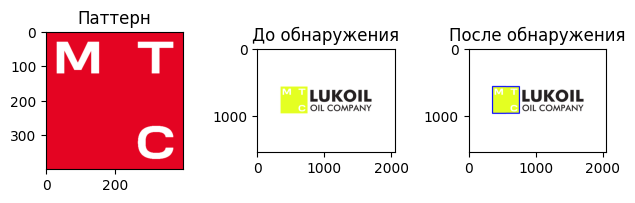

In [35]:
is_detected, detected, matches = detect(recolored_mts_on_lukoil_logo, mts_logo)
print(is_detected)

show_in_row(
    [mts_logo, recolored_mts_on_lukoil_logo, detected],
    titles=["Паттерн", "До обнаружения", "После обнаружения"],
)

## Итог

Получили функцию, которая способна неплохо обнаруживать паттерн на картинке, используя даже бейзлайн решение.

В дальнейшем, можно поиграться с подбором гиперпараметров, детекторов, и метчеров, а также попробовать подходы глубого обучения по типу yolo при условии, что есть размеченный датасет.